# Diversity of Ideas: Harvard Columns

## Setup

In [1]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [2]:
import pandas as pd
from util.ouraws import (
    getFromFile
)

In [3]:
%pwd

'c:\\Users\\theod\\OneDrive\\dev\\diversity-ideas\\notebooks\\2024'

In [4]:
df = getFromFile("../../data/harvard-columns.parquet", False)
df.shape


(3591, 6)

In [5]:
df.head(4)

,title,url,body,year,month,day
0,The Conversation,https://www.thecrimson.com/image/2020/5/5/illu...,The Conversation\n<p><strong>Want to keep up w...,2020,5,5
1,A Time for New Ideas,https://www.thecrimson.com/image/2020/5/4/illu...,A Time for New Ideas\nWant to keep up with bre...,2020,5,4
2,Daring to Be,https://www.thecrimson.com/image/2020/4/29/ill...,Daring to Be | Opinion | The Harvard Crimson\n...,2020,4,29
3,Plain Truth,https://www.thecrimson.com/image/2020/4/28/ill...,Plain Truth\nBy Helen H. Wang,2020,4,28


## Function Definitions

In [6]:
import numpy as np
import re

In [7]:
def getCovDispersion(wv):
    """
    Calculate various dispersion measures using the covariance matrix of word vectors.
    
    Args:
        wv: numpy array of shape (n_documents, embedding_dim) containing document embeddings
        
    Returns:
        tuple containing:
        - N: number of documents
        - trace_norm: average variance along the diagonal
        - l1_norm: L1 norm of covariance matrix (normalized)
        - l2_norm: L2 norm of covariance matrix (normalized)
        - inf_norm: Infinity norm of covariance matrix (normalized)
    """
    # Get number of documents
    N = len(wv)
    
    # Calculate covariance matrix of the word vectors
    # This measures how dimensions vary together across documents
    cov = np.cov(wv)
    
    return (
        N,  # Number of documents
        np.trace(cov)/N,  # Average variance along diagonal (spread in each dimension)
        np.linalg.norm(cov, ord=1)/N,  # L1 norm (sum of absolute values)
        np.linalg.norm(cov, ord=2)/N,  # L2/Spectral norm (largest singular value)
        np.linalg.norm(cov, ord=np.inf)/N,  # Infinity norm (max absolute row sum)
    )

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    a = np.array(v1, dtype=np.float64)
    b = np.array(v2, dtype=np.float64)
    # Calculate dot product and magnitudes of the input arrays
    dot   = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    if np.isclose(a_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"a_mag is very small: {a_mag}")
    if np.isclose(b_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"b_mag is very small: {b_mag}")
    
    # Calculate and return the cosine distance
    return 1.0 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [8]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]

In [9]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [11]:
diversity_pattern = "|".join(diversity_lemmas)

Let's verify how the "count" of diversity words in the text is calculated.

In [12]:
text = "This is a multicultural organization that advocates for diversity and racial justice."
len(re.findall(diversity_pattern, text))

3

## Analysis

In [13]:
from openai import OpenAI
from typing import List
import numpy as np
client = OpenAI()

In [14]:
def get_embedding(text: str) -> List[float]:
    """
    Get embeddings for a single text using text-embedding-3-large model.
    
    Args:
        text (str): The input text to generate embeddings for
        
    Returns:
        List[float]: The embedding vector
    """
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=text,
        dimensions=1024  # Optional: You can specify 256, 512, or 1024 dimensions
    )
    return response.data[0].embedding

def get_batch_embeddings(texts: List[str]) -> List[List[float]]:
    """
    Get embeddings for multiple texts in a single API call.
    
    Args:
        texts (List[str]): List of input texts to generate embeddings for
        
    Returns:
        List[List[float]]: List of embedding vectors
    """
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=texts,
        dimensions=1024
    )
    return [item.embedding for item in response.data]

In [15]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    # Step 1: Clean and normalize each text in the series
    # - Convert to lowercase
    # - Lemmatize each word (convert to base form)
    # - Remove stopwords
    # - Join words back together with spaces
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split()
                           if w not in english_stopwords))
    
    # Step 2: Filter out short texts
    # Remove any text less than 100 characters as they're likely too short for meaningful analysis
    text_series = text_series.apply(lambda x: x if len(x) > 100 else None)
    
    # Step 3: Remove any null values created by the previous step
    text_series = text_series.dropna()
    
    # Step 4: Count diversity-related terms
    # Sum up all instances of diversity-related words (defined in diversity_pattern)
    # across all remaining texts in the series
    total_diversity_words = sum([len(re.findall(diversity_pattern, text))
                                for text in text_series])
    
    # Return both the cleaned text series and the total count of diversity words
    return text_series, total_diversity_words

In [17]:
START_YEAR = 2009
FINAL_YEAR = 2024

In [18]:
year_2024 = df[df.year==2024]
clean_df, num_diversity_words = prepText(year_2024.body)
wv = get_batch_embeddings(clean_df)

In [19]:
type(wv[0])

list

In [20]:
docmatrix = np.array(wv)

In [21]:
docmatrix.shape

(181, 1024)

In [22]:
pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
cov = getCovDispersion(docmatrix)
print(f"{year_2024.year}, {cov[0]}, {cov[1]}, {pairwise}")

2966    2024
2967    2024
2968    2024
2969    2024
2970    2024
        ... 
3143    2024
3145    2024
3148    2024
3149    2024
3151    2024
Name: year, Length: 181, dtype: int64, 181, 0.0009770398715801762, 0.42935107542275847


In [23]:
pairwise

0.42935107542275847

In [24]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]
    
    clean_df, num_diversity_words = prepText(year_df.body)
    wv = get_batch_embeddings(clean_df)
    
    docmatrix = np.array(wv)
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    cov = getCovDispersion(docmatrix)
    
    print(f"{year}, {cov[0]}, {cov[1]}, {pairwise}")
    
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2],
              'norm-2':   cov[3],
              'norm-inf': cov[4],
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0]
             }
    results.append(result)

2009, 97, 0.0009764359825871267, 0.5635397872899746
2010, 242, 0.0009766815509664015, 0.5815995444865221
2011, 195, 0.0009767453291508667, 0.5698845978718621
2012, 149, 0.0009767540467370854, 0.5422927903082451
2013, 233, 0.0009768768165249748, 0.5871536729183635
2014, 234, 0.0009767189887102525, 0.5989810452302488
2015, 270, 0.000976802446894362, 0.5792106990124496
2016, 214, 0.0009768402416500653, 0.5740985074287062
2017, 203, 0.0009769587301618238, 0.5557836841196659
2018, 236, 0.0009769105180216936, 0.553038129483643
2019, 181, 0.000976879995220465, 0.5325617228479852
2020, 150, 0.0009767176998770114, 0.5517634559463238
2021, 124, 0.0009770546229313328, 0.49174072515020073
2022, 119, 0.0009770133282840441, 0.43844762820861416
2023, 140, 0.0009766924757976458, 0.5636343030695828
2024, 181, 0.0009770390092972132, 0.42940679981366886


In [25]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm
year,,,,,,,,
2009,0.563540,97,0.000976,0.000514,0.000437,0.000514,13,0.134021
2010,0.581600,242,0.000977,0.000497,0.000416,0.000497,61,0.252066
2011,0.569885,195,0.000977,0.000532,0.000427,0.000532,52,0.266667
2012,0.542293,149,0.000977,0.000549,0.000455,0.000549,70,0.469799
2013,0.587154,233,0.000977,0.000497,0.000411,0.000497,82,0.351931
2014,0.598981,234,0.000977,0.000498,0.000403,0.000498,74,0.316239
2015,0.579211,270,0.000977,0.000519,0.000422,0.000519,125,0.462963
2016,0.574099,214,0.000977,0.000540,0.000428,0.000540,74,0.345794
2017,0.555784,203,0.000977,0.000535,0.000444,0.000535,165,0.812808


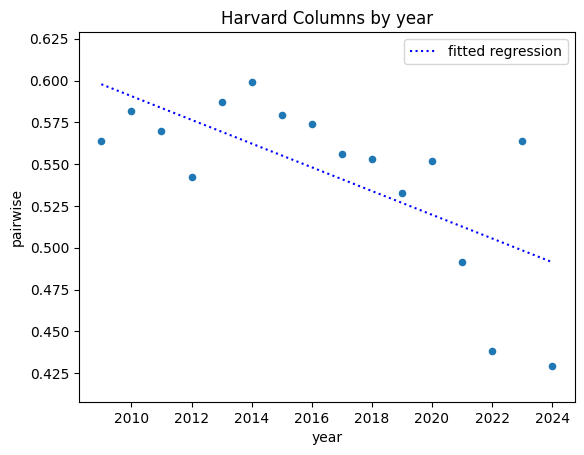

In [26]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="pairwise", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Harvard Columns by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

mentions-norm slope:0.06652, int:0.10160, r:0.84290, p:0.00004, se:0.01135, x:range(0, 16)
pairwise slope:-0.00709, int:0.59777, r:-0.67720, p:0.00395, se:0.00206, x:range(0, 16)


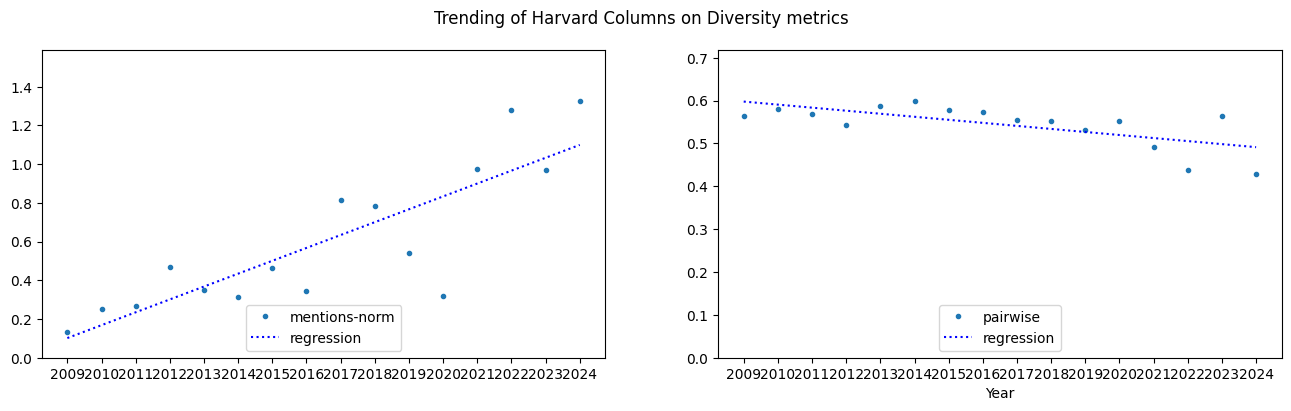

In [27]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)
    
plt.xlabel("Year")
plt.suptitle("Trending of Harvard Columns on Diversity metrics")
plt.show()

In [28]:
from scipy.stats import t

confidence_level = 0.95
degrees_of_freedom = len(x) - 2
t_value = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

margin_of_error = t_value * std_err

ci_lower = slope - margin_of_error
ci_upper = slope + margin_of_error

print(f"Slope: {slope:.5f}")
print(f"95% Confidence Interval: ({ci_lower:.5f}, {ci_upper:.5f})")
print(f"Standard Error: {std_err:.5f}")
print(f"P-value: {p_value:.5f}")

Slope: -0.00709
95% Confidence Interval: (-0.01151, -0.00268)
Standard Error: 0.00206
P-value: 0.00395
